### 원문 벡터 db + QA 벡터 DB -> 답변 평가 후 -> 3개의 검색 쿼리 재생성 -> 재실행
```
extract_queries → split_queries → tool → qa_tool → basic 
→ evaluate ── good → END
            └─ bad → 질문 재생성 → tool → qa_tool → basic → evaluate → END
```

- 3개의 검색 쿼리
    - 영문 질문
    - 한글 질문
    - 가짜 문서

In [1]:
from pathlib import Path
import sys

root = Path.cwd()
while not (root / "utils_v7").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root))

from utils_v7.main3 import (run_langraph)

c:\Users\playdata2\miniconda3\envs\final-clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Workspaces\SKN14-Final-1Team-AI\LLM_hybrid\utils_v7\retriever.py:51: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vs = Chroma(


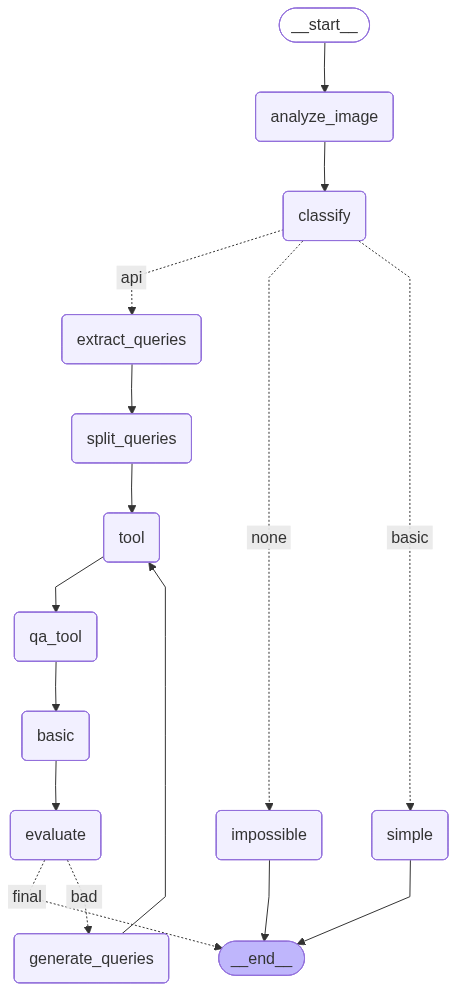

In [2]:
from utils_v7.langgraph_setting2 import graph_setting

graph = graph_setting()

graph

In [ ]:
response = run_langraph('YouTube Data API를 사용하여 동영상을 업로드할때, 빅쿼리 인서트문 사용하는법 알려주세요 ', '1', None)
print(response)

In [ ]:
# print(response['answer'])
print(response['tool_calls'])

In [ ]:
## 환경설정
!pip install -qU ragas langchain langchain-community langchain-openai langchain-chroma langchain-text-splitters pypdf rapidfuzz langgraph gdown chromadb langchain-huggingface sentence-transformers -q

In [ ]:
!pip install ragas

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()
# 필요한 라이브러리 임포트
import os
import pandas as pd
from pprint import pprint
# LangChain 관련 라이브러리
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# RAGAS 관련 라이브러리
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.persona import Persona
from ragas.testset import TestsetGenerator
from ragas import EvaluationDataset, evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

## 이미 만들어진 데이터셋 사용 시 스킵

## 이미 생성된 합성 데이터셋 생성

In [4]:
import pandas as pd

file_path = './dataset2.csv'
dataset_df = pd.read_csv(file_path)
pd.set_option('display.max_colwidth', None)

dataset_df.head()

,user_input,reference_contexts,reference,synthesizer_name
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,"['Q: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서 어떤 작업을 수행해야 하나요?\nA: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 인증서를 업로드해야 합니다. 그런 다음 만료일이 가장 늦은 인증서를 기본값으로 설정하는 작업을 수행해야 합니다.']","CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 인증서를 업로드해야 합니다. 그리고 만료일이 가장 늦은 인증서를 기본값으로 설정하는 작업을 해야 합니다.",single_hop_specific_query_synthesizer
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,['Q: Cloud Firestore의 부하 분산 기능은 어떻게 작동하나요?\nA: Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 확장되므로 부하 분산기를 실행할 필요가 없습니다.'],Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 확장되므로 부하 분산기를 실행할 필요가 없습니다.,single_hop_specific_query_synthesizer
2,범위 많으면 동의 어렵나요?,['Q: OAuth 2.0을 사용할 때 요청하는 범위의 수가 사용자 동의에 미치는 영향은 무엇인가요?\nA: 범위를 사용 설정하면 애플리케이션은 필요한 리소스에 대한 액세스만 요청하고 사용자는 애플리케이션에 부여하는 액세스 양을 제어할 수 있습니다. 따라서 요청된 범위 수와 사용자 동의를 얻을 가능성 간에 역관계가 있을 수 있습니다. OAuth 2.0 승인을 구현하기 전에 앱에서 액세스 권한이 필요한 범위를 지정하는 것이 좋습니다.'],요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,single_hop_specific_query_synthesizer
3,"As a beginner who is not familiar with Google APIs, could you please explain in detail how the Cloud Platform is affected when Google Cloud session control features are enabled, and what specific user actions or applications are impacted by these policies?","['Q: Google Cloud 세션 제어 기능이란 무엇이며, 어떤 영향을 미치나요?\nA: GCP 조직의 관리자는 Google Cloud 세션 제어 기능을 사용하여 사용자가 GCP 리소스에 액세스하는 동안 사용자의 재인증을 자주 요구할 수 있습니다. 이 정책은 Google Cloud Console, Google Cloud SDK (gcloud CLI라고도 함), Cloud Platform 범위가 필요한 서드 파티 OAuth 애플리케이션에 대한 액세스에 영향을 미칩니다.']","When Google Cloud session control features are enabled, administrators in a GCP organization can require users to re-authenticate more frequently while accessing GCP resources. This policy affects access to the Google Cloud Console, the Google Cloud SDK (also known as gcloud CLI), and third-party OAuth applications that require Cloud Platform scopes.",single_hop_specific_query_synthesizer
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Firestore에서 문서 바뀔 때마다 자동으로 뭔가 실행되게 하려면 firebase_functions에서 뭘 써야 되고, 예시 코드도 보여줄 수 있나요?","['Q: Cloud Firestore에서 특정 문서의 모든 변경에 대해 이벤트를 트리거하려면 어떤 함수를 사용해야 하나요?\nA: 특정 문서의 모든 변경에 이벤트를 트리거하려면 `onDocumentWritten` 함수를 사용해야 합니다. 예시는 다음과 같습니다.\n\n```python\nfrom firebase_functions.firestore_fn import (\n on_document_written,\n Event,\n Change,\n DocumentSnapshot,\n)\n\n@on_document_written(document=""users/marie"")\ndef myfunction(event: Event[Change[DocumentSnapshot]]) -> None:\n # Get an object with the current document values.\n # If the document does not exist, it was deleted.\n document = (event.data.after.to_dict()\n if event.data.after is not None else None)\n\n # Get an object with the previous document values.\n # If the document does not exist, it was newly created.\n previous_values = (event.data.before.to_dict()\n if event.data.before is not None else None)\n\n # Perform more operations ...\n```']","Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 onDocumentWritten 함수를 사용해야 합니다. 예시는 다음과 같습니다.\n\nfrom firebase_functions.firestore_fn import (\n on_document_written,\n Event,\n Change,\n DocumentSnapshot,\n)\n\n@on_document_written(document=""users/marie"")\ndef myfunction(event: Event[Change[DocumentSnapshot]]) -> None:\n # Get an object with the current document values.\n # If the document does not exist, it was deleted.\n document = (event.data.after.to_dict()\n if event.data.after is not None else None)\n\n # Get an object with the previous document values.\n # If the document does not exist, it was newly created.\n previous_values = (event.data.before.to_dict()\n if event.data.before is not None else None)\n\n # Perform more operations ...",single_hop_specific_query_synthesizer


In [5]:

## 02.RAG 체인 구성

import pandas as pd
from datasets import Dataset
import uuid
import time

evaluated_dataset = []

for _, row in dataset_df.iterrows():
    query = row.user_input  # 사용자 입력 - 합성 데이터셋에서 가져옴
    time.sleep(5)
    
    # run_langraph 함수 호출
    rag_result = run_langraph(query,'1', None)

    evaluated_dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": [doc for doc in rag_result["search_results"]],
            "response": rag_result["answer"],
            "reference": row['reference']
        }
    )

print("평가 데이터셋 준비 완료")

# RAGAS 평가 데이터셋 생성
v7_evaluated_dataset = Dataset.from_list(evaluated_dataset)

run_langraph 호출 - 입력: CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
[tool_based_search_node] 실행 - queries=['CSV 파일을 이용한 S/MIME 인증서 관리 방법은 무엇인가요?']
[vector_search_tool] 검색 중: 'CSV 파일을 이용한 S/MIME 인증서 관리 방법' with filters: {'tags': {'$in': ['gmail']}}
[tool_based_search_node] 실행 - state['search_results']=['except (OSError, IOError) as error:\n    print(f"An error occured while reading the CSV file: {error}")\n\n\nif __name__ == "__main__":\n  insert_cert_from_csv(csv_filename="xyz")\n인증서 관리\n이 예에서는 smimeInfo API의 여러 호출을 결합하여 조직의 인증서를 관리하는 방법을 보여줍니다. 사용자의 인증서를 나열하고 기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 찾은 인증서를 업로드합니다. 그런 다음 만료일이 가장 늦은 인증서를 기본값으로 설정합니다.\n그런 다음 이전 예와 같이 CSV 파일을 처리하는 함수에서 이를 호출합니다.\n--- 탭: 자바 ---\n.filepath {\n    color: #fff;\n    margin: 6px;\n    max-width: calc(100% - 160px); /* Give at least 160px for the "View on GitHub" button. */\n    text-overflow: ellipsis;\n    text-shadow: rgba(0,0,0,0.1) 1px 1px;\n    overflow: hidden;\n  

In [6]:
v7_evaluated_dataset = v7_evaluated_dataset.to_pandas()

In [ ]:
# csv 데이터 저장
v7_evaluated_dataset.to_csv('v7_evaluated_dataset.csv', index=False)

In [7]:
v7_evaluated_dataset.head()

user_input  \
0                                                                                                                                                                                                                      CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?   
1                                                                                                                                                                                                                                     클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?   
2                                                                                                                                                                                                                                                   범위 많으면 동의 어렵나요?   
3  As a beginner who is not familiar with Google APIs, could you please explain in detail how the Cloud Platform is affected when Google Cloud session control features are enabled, and what specific user actions or applications are impacted by these policies?   
4                                                                                                                                  firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Firestore에서 문서 바뀔 때마다 자동으로 뭔가 실행되게 하려면 firebase_functions에서 뭘 써야 되고, 예시 코드도 보여줄 수 있나요?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# 03. 개별 답변 평가
- results_df: 
	- 다음 4가지 평가 기준으로 1-5점 척도로 점수 평가
	1. 응답 정확성 (Answer Correctness) : 1-5점
	2. 컨텍스트 관련성 (Context Relevance) : 1-5점
	3. 컨텍스트 충실성 (Context Faithfulness) : 1-5점
	4. 컨텍스트 충분성 (Context Recall) : 1-5점
	5. total_score : 총점
	6. analysis: 종합적인 분석 의견

In [ ]:
# import pandas as pd

# file_path = './v4_evaluated_dataset.csv'
# v4_evaluated_dataset = pd.read_csv(file_path)
# pd.set_option('display.max_colwidth', None)

In [8]:
import pandas as pd
import json
import os
from tqdm import tqdm
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def evaluate_rag_with_llm(data_df):
    """
    LLM 평가 메트릭으로 RAG 시스템 평가

    Args:
        data_df (pd.DataFrame): 'user_input', 'retrieved_contexts', 'response', 'reference'
                                 열을 포함하는 데이터프레임

    Returns:
        평가 결과가 포함된 데이터프레임 및 요약 정보
    """
    user_inputs = data_df['user_input'].tolist()
    retrieved_contexts = data_df['retrieved_contexts'].tolist()
    responses = data_df['response'].tolist()
    references = data_df['reference'].tolist()

    results = []

    prompt_template = """당신은 RAG(Retrieval-Augmented Generation) 시스템 평가 전문가입니다. 아래 정보를 바탕으로 생성된 답변의 품질을 철저히 평가해주세요.

질문: {user_input}

검색된 컨텍스트:
{retrieved_context}

생성된 답변:
{response}

참조 답변(정답):
{reference}

다음 4가지 평가 기준으로 1-5점 척도로 점수를 매겨주세요:

1. 응답 정확성 (Answer Correctness) [1-5]:
    * 생성된 답변이 참조 답변과 비교하여 정확하고 완전한 정보를 제공하는지 평가
    * 1점: 완전히 잘못된 정보
    * 2점: 부분적으로 관련된 정보를 담고 있으나 대부분 부정확함
    * 3점: 정확한 정보와 부정확한 정보가 혼재되어 있음
    * 4점: 대부분 정확하지만 일부 정보가 누락되거나 미미한 오류가 있음
    * 5점: 참조 답변과 비교했을 때 완전히 정확하고 포괄적인 정보를 제공함

2. 컨텍스트 관련성 (Context Relevance) [1-5]:
    * 검색된 컨텍스트가 질문에 대답하기 위해 관련성이 높은지 평가
    * 1점: 컨텍스트가 질문과 전혀 관련이 없음
    * 2점: 컨텍스트가 질문과 간접적으로만 관련됨
    * 3점: 컨텍스트 중 일부만 질문과 직접적으로 관련됨
    * 4점: 대부분의 컨텍스트가 질문과 직접적으로 관련됨
    * 5점: 모든 컨텍스트가 질문에 완벽하게 관련되어 있고 불필요한 정보가 없음

3. 컨텍스트 충실성 (Context Faithfulness) [1-5]:
    * 생성된 답변이 주어진 컨텍스트에만 기반하는지, 아니면 없는 정보를 추가했는지 평가
    * 1점: 답변이 컨텍스트에 없는 정보로만 구성됨 (심각한 환각)
    * 2점: 답변이 주로 컨텍스트에 없는 정보로 구성됨
    * 3점: 답변이 컨텍스트 정보와 없는 정보가 혼합되어 있음
    * 4점: 답변이 주로 컨텍스트에 기반하지만 약간의 추가 정보가 있음
    * 5점: 답변이 전적으로 컨텍스트에 있는 정보만을 사용함

4. 컨텍스트 충분성 (Context Recall) [1-5]:
    * 검색된 컨텍스트가 질문에 완전히 답변하기에 충분한 정보를 포함하는지 평가
    * 1점: 컨텍스트가 답변에 필요한 정보를 전혀 포함하지 않음
    * 2점: 컨텍스트가 필요한 정보의 일부만 포함함
    * 3점: 컨텍스트가 필요한 정보의 약 절반을 포함함
    * 4점: 컨텍스트가 필요한 정보의 대부분을 포함하지만 일부 누락됨
    * 5점: 컨텍스트가 질문에 완전히 답변하기 위한 모든 필요한 정보를 포함함

반드시 다음 JSON 형식으로만 응답하세요. 마크다운은 사용하지 않습니다.:
{{
 "answer_correctness": 0,
 "context_relevance": 0,
 "context_faithfulness": 0,
 "context_recall": 0,
 "analysis": "종합적인 분석 의견"
}}

다른 형식의 응답은 하지 마세요. 오직 마크다운이 아닌 JSON만 반환하세요."""

    # 각 항목에 대해 평가 수행
    for i in tqdm(range(len(user_inputs)), total=len(user_inputs), desc="RAG 평가 진행 중"):
        try:
            # 프롬프트 생성
            prompt = prompt_template.format(
                user_input=user_inputs[i],
                retrieved_context=retrieved_contexts[i],
                response=responses[i],
                reference=references[i]
            )

            # GPT-4o API 호출
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "당신은 RAG 평가 도구입니다. 반드시 유효한 JSON 형식으로만 응답하세요."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                response_format={"type": "json_object"}
            )
            
            # 결과 파싱
            result = json.loads(response.choices[0].message.content)
            
            # 개별 메트릭 점수 추출
            answer_correctness = result.get('answer_correctness', 1)
            context_relevance = result.get('context_relevance', 1)
            context_faithfulness = result.get('context_faithfulness', 1)
            context_recall = result.get('context_recall', 1)
            analysis = result.get('analysis', "파싱 오류 또는 결과 누락")

            # 총점 직접 계산 (개별 메트릭의 합)
            total_score = answer_correctness + context_relevance + context_faithfulness + context_recall
            
            # 원본 데이터와 평가 결과 결합
            row_result = {
                'id': i,
                'user_input': user_inputs[i],
                'answer_correctness': answer_correctness,
                'context_relevance': context_relevance,
                'context_faithfulness': context_faithfulness,
                'context_recall': context_recall,
                'total_score': total_score,
                'analysis': analysis
            }
            
            results.append(row_result)
            
        except Exception as e:
            print(f"항목 {i} 평가 중 오류 발생: {e}")
            results.append({
                'id': i,
                'user_input': user_inputs[i],
                'error': str(e)
            })
    
    results_df = pd.DataFrame(results)
    
    if 'total_score' in results_df.columns:
        metrics_summary = {
            '평균 총점': results_df['total_score'].mean(),
            '응답 정확성 평균': results_df['answer_correctness'].mean(),
            '컨텍스트 관련성 평균': results_df['context_relevance'].mean(),
            '컨텍스트 충실성 평균': results_df['context_faithfulness'].mean(),
            '컨텍스트 충분성 평균': results_df['context_recall'].mean()
        }
        print("\n===== 평가 요약 =====")
        for metric, value in metrics_summary.items():
            print(f"{metric}: {value:.2f}")
    
    return results_df, metrics_summary if 'total_score' in results_df.columns else results_df

## QA

In [9]:
v7_results_df, v7_metrics_summary = evaluate_rag_with_llm(v7_evaluated_dataset)

RAG 평가 진행 중: 100%|██████████| 20/20 [01:59<00:00,  5.98s/it]


===== 평가 요약 =====
평균 총점: 17.75
응답 정확성 평균: 4.25
컨텍스트 관련성 평균: 4.55
컨텍스트 충실성 평균: 4.60
컨텍스트 충분성 평균: 4.35


In [10]:
v7_results_df

,id,user_input,answer_correctness,context_relevance,context_faithfulness,context_recall,total_score,analysis
0,0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,4,5,5,4,18,"생성된 답변은 CSV 파일을 이용한 S/MIME 인증서 관리에 대한 절차를 잘 설명하고 있으며, 주어진 컨텍스트와 일치합니다. 특히, CSV 파일의 구조와 이를 처리하는 함수의 예시를 제공하여 실용적인 정보를 포함하고 있습니다. 다만, 참조 답변에서 언급된 '기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 인증서를 업로드하고 만료일이 가장 늦은 인증서를 기본값으로 설정하는 작업'에 대한 구체적인 설명이 부족합니다. 전반적으로, 생성된 답변은 정확하고 관련성이 높으며, 주어진 컨텍스트에 충실합니다. 그러나 컨텍스트가 질문에 완전히 답변하기에는 약간의 정보가 부족합니다."
1,1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,5,5,5,5,20,"생성된 답변은 참조 답변과 비교했을 때 정확하고 포괄적인 정보를 제공하며, 검색된 컨텍스트와 완벽하게 일치합니다. Cloud Firestore의 자동 확장 기능에 대한 설명이 명확하게 제공되었고, 부하 분산기를 별도로 실행할 필요가 없다는 점이 잘 전달되었습니다. 따라서 모든 평가 기준에서 최고 점수를 받을 만합니다."
2,2,범위 많으면 동의 어렵나요?,1,2,1,2,6,"생성된 답변은 질문에 대한 정확한 정보를 제공하지 못하고 있으며, 검색된 컨텍스트와 관련성이 낮습니다. 컨텍스트는 Cloud Firestore의 기술적 세부사항에 관한 내용으로, 질문의 범위와 동의에 대한 직접적인 답변을 제공하지 않습니다. 따라서 생성된 답변은 컨텍스트에 기반하지 않고, 질문에 대한 정확한 답변을 제공하지 못합니다."
3,3,"As a beginner who is not familiar with Google APIs, could you please explain in detail how the Cloud Platform is affected when Google Cloud session control features are enabled, and what specific user actions or applications are impacted by these policies?",5,5,5,5,20,"생성된 답변은 참조 답변과 비교했을 때 정확하고 포괄적인 정보를 제공하며, 검색된 컨텍스트에 기반하여 충실하게 작성되었습니다. 컨텍스트는 질문에 완전히 관련되어 있으며, 질문에 답변하기에 충분한 정보를 포함하고 있습니다. 따라서 모든 평가 기준에서 높은 점수를 받을 수 있습니다."
4,4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Firestore에서 문서 바뀔 때마다 자동으로 뭔가 실행되게 하려면 firebase_functions에서 뭘 써야 되고, 예시 코드도 보여줄 수 있나요?",5,5,5,5,20,"생성된 답변은 참조 답변과 비교했을 때 정확하고 포괄적인 정보를 제공하고 있습니다. 검색된 컨텍스트는 질문에 대답하기 위해 매우 관련성이 높으며, 생성된 답변은 전적으로 컨텍스트에 있는 정보만을 사용하고 있습니다. 또한, 검색된 컨텍스트는 질문에 완전히 답변하기 위한 모든 필요한 정보를 포함하고 있습니다. 따라서 모든 평가 기준에서 최고 점수를 부여할 수 있습니다."
5,5,"Firebase에서 다단계 인증(MFA)을 사용할 때 Objective-C로 사용자 인증을 완료하는 방법과 관련된 코드 예시가 궁금합니다. 어떤 방식으로 인증 정보를 가져오고, Objective-C에서는 어떻게 구현하나요?",4,5,5,4,18,"생성된 답변은 주어진 컨텍스트에 기반하여 Firebase의 다단계 인증을 Objective-C로 구현하는 방법을 잘 설명하고 있습니다. 컨텍스트에서 제공된 코드 예시를 충실히 반영하고 있으며, 다단계 인증을 위한 FIRMultiFactorResolver의 사용을 정확히 설명하고 있습니다. 다만, 참조 답변에서 언급된 FIRMultiFactorAssertion의 사용에 대한 설명이 누락되어 있어 완전한 정보 제공에는 약간의 부족함이 있습니다. 그러나 전반적으로 정확하고 관련성이 높은 정보를 제공하고 있습니다."
6,6,Java를 사용해서 Firestore에 문서를 추가할 때 어떤 코드를 사용하나요?,4,5,4,5,18,"생성된 답변은 Firestore에 문서를 추가하는 방법에 대해 정확한 정보를 제공하고 있으며, 검색된 컨텍스트와 잘 일치합니다. 특히, `set()`과 `add()` 메서드를 사용하는 방법을 설명하고 있어 질문에 대한 적절한 답변을 제공합니다. 다만, 참조 답변과 비교했을 때 데이터 구조의 예시가 다소 다르지만, 이는 Firestore에 데이터를 추가하는 방법의 본질적인 차이를 만들지 않습니다. 따라서 응답 정확성에서 약간의 점수를 감점하였습니다. 전반적으로 컨텍스트는 질문에 대한 충분한 정보를 제공하고 있으며, 생성된 답변은 주로 컨텍스트에 기반하고 있습니다."
7,7,COLUMNS가 Dimension API에서 무슨 뜻인가요?,1,2,5,1,9,"생성된 답변은 주어진 컨텍스트에 기반하여 Dimension API에 대한 정보가 없음을 언급하고 있습니다. 이는 컨텍스트 충실성 측면에서는 높은 점수를 받을 수 있지만, 실제로 질문에 대한 정확한 답변을 제공하지 못했습니다. 검색된 컨텍스트는 Dimension API에 대한 정보를 포함하지 않으며, 따라서 질문에 대한 충분한 답변을 제공하기에 부족합니다. 컨텍스트의 관련성도 낮으며, 질문에 직접적으로 관련된 정보가 거의 없습니다."
8,8,ttll이 뭐에요? 그리고 한도 같은거 있나요?,4,5,5,5,19,"생성된 답변은 TTL의 개념과 관련 한도에 대해 정확하고 포괄적인 정보를 제공하고 있습니다. 참조 답변과 비교했을 때, 생성된 답변은 대부분의 정보를 포함하고 있으며, 일부 세부사항이 누락되었지만 전반적으로 정확합니다. 검색된 컨텍스트는 질문에 대한 답변을 제공하기에 충분하며, 생성된 답변은 주어진 컨텍스트에 충실하게 기반하고 있습니다."
9,9,Me want know what FUNCTION_ENTRYPOINT do in gcloud run deploy command?,5,4,5,4,18,"생성된 답변은 FUNCTION_ENTRYPOINT의 역할을 정확하게 설명하고 있으며, 참조 답변과 비교했을 때 완전하고 정확한 정보를 제공하고 있습니다. 검색된 컨텍스트는 질문에 대한 답변을 제공하기에 충분한 정보를 포함하고 있으며, 생성된 답변은 이 컨텍스트에 충실합니다. 다만, 컨텍스트의 일부만이 질문과 직접적으로 관련되어 있어 컨텍스트 관련성 점수가 약간 낮습니다."


In [ ]:
v7_results_df.to_csv('v7_evaluation_results.csv', index=False)

In [ ]:
v7_metrics_summary

## QA 일상 질문 + 전문지식 답변

### 일상 + 전문 지식 질문

In [ ]:
import pandas as pd

file_path = './dataset_test.csv'
dataset_test_df = pd.read_csv(file_path)
pd.set_option('display.max_colwidth', None)

dataset_test_df.head()

In [ ]:
dataset_test_df['response'] = ''
dataset_test_df['retrieved_contexts'] = ''

print("RAG 답변 생성을 시작합니다...")

# 데이터프레임의 각 행을 순회하며 RAG 답변 생성
for index, row in tqdm(dataset_test_df.iterrows(), total=len(dataset_test_df), desc="답변 생성 진행 중"):
    query = row['user_input']
    
    # run_graph 함수 호출
    rag_result = run_langraph(query,'1', None)

    # RAG 결과 저장
    dataset_test_df.at[index, 'response'] = rag_result['answer']
    
    try:
        contexts_list = [doc.page_content for docs_list in rag_result["search_results"] for doc in docs_list]
        dataset_test_df.at[index, 'retrieved_contexts'] = json.dumps(contexts_list, ensure_ascii=False)
    except (TypeError, KeyError):
        dataset_test_df.at[index, 'retrieved_contexts'] = json.dumps([], ensure_ascii=False)

print("\nRAG 답변 생성이 완료되었습니다.")

In [ ]:
dataset_test_df

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
from langchain_openai import ChatOpenAI

In [ ]:
from langchain_core.prompts import PromptTemplate

judge_prompt = PromptTemplate(
    template="""
당신은 AI 모델의 답변 행동을 평가하는 매우 엄격한 전문 심사위원입니다.
오직 지정된 JSON 형식으로만 답변해야 하며, 다른 어떠한 텍스트도 추가해서는 안 됩니다.
**만약 JSON 형식을 따르지 못하면, 당신의 임무는 실패로 간주됩니다.**

[질문 유형]
{question_type}

아래에 제공된 [질문]과 모델의 [답변], 그리고 [질문 유형]을 비교하여 모델이 올바르게 작동했는지 판단하세요.

**평가 기준:**
- **일상 질문:** 모델이 벡터 DB 검색을 거치지 않고 상식적이고 유용한 답변을 제공했습니까? 일상 질문의 경우, 제공할 수 없다는 부정적인 문구은 답변하지 말아야 합니다.
- **전문 지식:** 모델의 답변이 '제가 모르는 내용입니다. 일상 질문 혹은 구글 API 관련 질문만 답변드릴 수 있어요.'와 같은 거부 문구를 답변했나요? 동일한 거부 문구가 아니여도 됩니다.

**판단 과정:**
1.  **질문 유형 분류**: 제공된 [질문]이 '일상 질문'인지 '전문 지식' 질문인지 먼저 판단하세요.
2.  **행동 일치 여부 판단**: 질문 유형에 따라 모델의 [답변]이 평가 기준과 일치하는지 판단합니다.
3.  **추론 및 JSON 생성**: 판단 근거를 설명하고, 최종적으로 JSON 형식으로 응답을 생성합니다.

**응답은 반드시 다음 JSON 형식으로만 출력해주세요.**
{{
  "behavior_match": "True" 또는 "False",
  "reasoning": "판단 근거를 설명"
}}

[질문]
{user_input}

[모델 답변]
{response}
""",
    input_variables=["user_input", "response", "question_type"]
)

# 3. LLM 심사위원 체인 설정
judge_llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

In [ ]:
import re
import json

def evaluate_behavior_with_llm(data_df: pd.DataFrame) -> pd.DataFrame:
    eval_results = []

    for index, row in tqdm(data_df.iterrows(), total=len(data_df), desc="LLM 평가 진행 중"):
        user_input = row['user_input']
        response = row['response']
        question_type = row['question_type']

        # 프롬프트 생성
        formatted_prompt = judge_prompt.format(
            user_input=user_input,
            response=response,
            question_type=question_type
        )

        try:
            # LLM 호출
            judgement_response = judge_llm.invoke(formatted_prompt)

            # 응답 안전 추출
            if isinstance(judgement_response.content, str):
                raw_output = judgement_response.content.strip()
            else:
                # [{"type":"text","text":"..."}] 형태일 때
                raw_output = judgement_response.content[0]["text"].strip()

            # JSON 패턴만 추출
            json_match = re.search(r"\{.*\}", raw_output, re.DOTALL)
            if not json_match:
                raise ValueError(f"JSON 패턴을 찾을 수 없음. 원본 응답: {raw_output}")

            judgement = json.loads(json_match.group())

            eval_results.append({
                "user_input": user_input,
                "response": response,
                "question_type": question_type,
                "behavior_match": judgement.get("behavior_match"),
                "reasoning": judgement.get("reasoning")
            })

        except Exception as e:
            eval_results.append({
                "user_input": user_input,
                "response": response,
                "question_type": question_type,
                "behavior_match": "False",
                "reasoning": f"JSON 파싱 오류: {str(e)}"
            })
    
    return pd.DataFrame(eval_results)

In [ ]:
final_df = evaluate_behavior_with_llm(dataset_test_df)

In [ ]:
final_df

In [ ]:
final_df.to_csv("v7_test_results.csv", index=False)

In [ ]:
import pandas as pd

summary = final_df.groupby("question_type")["behavior_match"].apply(
    lambda x: f"{(x == 'True').sum()} / {len(x)}"
).reset_index(name="ratio")

print(summary)
